### Correlated-Sample Tests

Hollander and Wolfe's [Nonparametric Statistic methods](https://onlinelibrary.wiley.com/doi/book/10.1002/9781119196037) considers data from [[6](https://www.jci.org/articles/view/106443)], which studied the relationship between free proline (an amino acid) and total collagen (a protein often found in connective tissue) in diseased human livers.

The `x` and `y` arrays below record the measurements of the two compounds.

In [1]:
import numpy as np
x = np.array([7.1, 7.1, 7.2, 8.3, 9.4, 10.5, 11.4])  # total collagen (mg/g dry weight of liver)
y = np.array([2.8, 2.9, 2.8, 2.6, 3.5, 4.6, 5.0])  # free proline (μ mole/g dry weight of liver)

The text shows the results of analysis using Spearman's correlation coeefficient, a statistic sensitive to linear association between the ranks of the samples. Specifically, the null hypothesis that there is no association between total collagen and free protein is tested against the alternative that there is a positive, linear association between the two.

In [2]:
from scipy import stats
res_asymptotic = stats.spearmanr(x, y, alternative='greater')
res_asymptotic

SpearmanrResult(correlation=0.7000000000000001, pvalue=0.03995834515444954)

As usual, the $p$-value of SciPy's `stats.spearmanr` approximates the probability of obtaining such an extreme value of the statistic under the null hypothesis. The small $p$-value corresponding with the positive correlation coefficient provides "marginal evidence" that the total collagen and free proline are positively correlated.

However, the $p$-value of `stats.spearmanr` is based on an asymptotic approximation, which may not be accurate for such a small sample. Even if `spearmanr` did implement an exact $p$-value calculation, it is unlikely that it would support data with ties due to the limitations of common algorithms. Therefore, we consider how a permutation test oculd be used to compute an exact $p$-value.

Under the null hypothesis, all the proline measurements are independent samples from the same distribution; they are uncorrelated with the measurements of collagen, and the observed pairings have no significance. Therefore, the null distribution is formed by computing the statistic for *all possible pairings* of proline and collagen measurements *without permuting samples*. Because `spearmanr` treats elements `x[i]` and `y[i]` as paired, we can accomplish this by computing the statistic for all possible orderings of only one of the two arrays (e.g. `y`).

Text(0, 0.5, 'Observed Frequency')

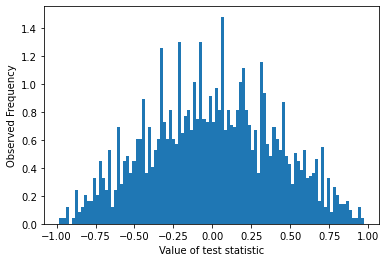

In [3]:
from itertools import permutations
import matplotlib.pyplot as plt

def statistic(x, y):
    return stats.spearmanr(x, y, alternative='greater').correlation

def null_distribution(x, y):
    # the order of `x` can remain fixed
    # By generating all possible orderings of `y` (alone),
    # we explore all possible pairings between observations
    # in `x` and `y`
    null_distribution = []
    for yperm in permutations(y):
        stat = statistic(x, yperm)
        null_distribution.append(stat)
    return null_distribution

null_dist = null_distribution(x, y)
plt.hist(null_dist, density=True, bins=100)
plt.xlabel("Value of test statistic")
plt.ylabel("Observed Frequency")

The $p$-value is the percentage of values in the null distribution that equal or exceed the observed value of the statistic.

In [4]:
pvalue = np.sum(null_dist >= statistic(x, y)) / len(null_dist)
print(f"Asymptotic p-value: {res_asymptotic.pvalue}")
print(f"Exact p-value: {pvalue}")

Asymptotic p-value: 0.03995834515444954
Exact p-value: 0.04563492063492063


The asymptotic p-value is reasonably accurate in this case, but it smaller. This suggests that the asymptotic approximation is not conservative; that is, it is more likely to lead to _Type I error_ - being taken as evidence against the null hypothesis even when the null hypothesis is actually true.

`permutation_test` can perform the same test using `permutation_type='pairings'` (so named because it forms the null distribution by permuting the pairings of the observations without permuting observations between samples).

In [5]:
def statistic(y):
    return stats.spearmanr(x, y).correlation
res = stats.permutation_test((y,), statistic, alternative='greater', permutation_type='pairings', n_resamples=np.infty)
assert res.pvalue == pvalue

Many other correlation tests can be performed as permutation tests. We continue with another example to help avoid common pitfalls in the usage of `permutation_test` with `permutation_type='pairings'`.

#### Gotchas

Another example of a correlation test in SciPy is `scipy.stats.kendalltau`.

In [6]:
# Each element in `x` is paired with the corresponding element of `y`
rng = np.random.default_rng()
x = rng.random(5)
y = rng.random(5)  
stats.kendalltau(x, y, alternative='two-sided')

KendalltauResult(correlation=-0.39999999999999997, pvalue=0.48333333333333334)

Like `mannwhitneyu` and `wilcoxon`, `kendalltau` computes its p-value using permutations. Using `kendalltau` to compute only the statistic, we could compute the same $p$-value with `permutation_test`.

In [7]:
def statistic(x, y):
    return stats.kendalltau(x, y).correlation
res = stats.permutation_test((x, y,), statistic, alternative='two-sided', permutation_type='pairings')
res.pvalue

0.4816

What happened here? In all cases before, `permutation_test` produced the exact p-value, but here we have only a four-digit approximation.

Note that the null distribution contains only 9999 elements, the default for a randomized test.

In [8]:
len(res.null_distribution)

9999

If we were to allow for unlimited permutations, `permutation_test` would eventually compute the exact answer. 

In [9]:
res = stats.permutation_test((x, y), statistic, alternative='two-sided', permutation_type='pairings', n_resamples=np.inf)

Then we can compute the $p$-value as the percentage of elements in the null distribution as extreme as the observed value of the test statistic. In this case, either large or small values are considered more extreme because `alternative='two-sided'`.  

In [10]:
pvalue = np.sum(np.abs(res.null_distribution) >= np.abs(statistic(x, y)) ) / len(res.null_distribution)
print(pvalue)

0.48333333333333334


Note that this definition only makes sense for distributions that are symmetric about a known median. To produce the same value for symmetric distributions but generalize to asymmetric distributions, `permutation_test` actually computes the p-value by doubling the minimum of the `'greater'` and `'less'` p-values.

In [11]:
pvalue_greater = np.sum(res.null_distribution >= statistic(x, y) ) / len(res.null_distribution)
pvalue_less = np.sum(res.null_distribution <= statistic(x, y) ) / len(res.null_distribution)
pvalue = 2 * min(pvalue_greater, pvalue_less)
print(pvalue)

0.48333333333333334


But let's step back a minute - theoretically, there are only $5!=120$ possible pairings of the observations between the two samples, so why did it take so many resamples to compute an exact answer? 

`permutation_test` permutes the orders of _all_ provided samples, so we computed all possible permutations of both `x` and `y`. That's $5! \cdot 5!=14,400$ permutations:

In [12]:
len(res.null_distribution)

14400

This is $5!$ times the amount of work it needed to do, since only the pairings between observations in `x` and `y` affect the statistic, not the order of the pairs within the arrays. We improve efficiency by leaving `x` out of the call to `permutation_test` and simply include it as part of the `statistic` itself.

In [13]:
def statistic(y):
    return stats.kendalltau(x, y, alternative='two-sided').correlation

res = stats.permutation_test((y,), statistic, alternative='two-sided', permutation_type='pairings')
assert len(res.null_distribution) == 120
print(res.pvalue)

0.48333333333333334


Again, `permutation_test` is particularly useful when there are ties because, according to the [`kendalltau` documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html):

> ‘exact’: computes the exact p-value, but can only be used if no ties are present. 

In [14]:
# with more observations than distinct values,
# there will be ties within and between samples
x = rng.integers(0, 5, size=7) 
y = rng.integers(0, 5, size=7)
try:
    stats.kendalltau(x, y, method='exact', alternative='two-sided')
except ValueError as e:
    print(f"{type(e).__name__}: {e}")

ValueError: Ties found, exact method cannot be used.


`permutation_test` has no such restriction. Since we are using `kendalltau` only to compute the correlation statistic, we can pass option `method='asymptotic'` to avoid the computational expense of computing exact p-values.

In [15]:
def statistic(y):
    return stats.kendalltau(x, y, alternative='two-sided', method='asymptotic').correlation

res = stats.permutation_test((y,), statistic, alternative='two-sided', permutation_type='pairings')
res.pvalue

0.5714285714285714

### Other Tests
`permutation_test` with `permutation_type='pairings'` is a versatile tool for assessing association between samples. Provided only data and a statistic, it can produce the null distribution and replicate the $p$-value of similar tests tests in SciPy, and it may be more accurate than these existing implementations, especially for small samples and when there are ties:

- [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)
- [`spearmanr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)
- [`kendalltau`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html)
- [`somersd`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.somersd.html)
- [`linregress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)

In addition, `permutation_test` with `permutation_type='pairings'` can be used to perform tests not yet implemented in SciPy.

But there is much more to statistics than $p$-values! We conclude with a discussion of one of the most versatile techniques of all: [the bootstrap](https://github.com/mdhaber/scipy/blob/resampling_tutorial/doc/source/tutorial/stats/notebooks/resampling_tutorial_3.ipynb).